<a href="https://colab.research.google.com/github/saqlainkazi690/Projects/blob/main/mlhackwavez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'unpaired-wavez:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4780730%2F8096728%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T171451Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Ddf9d5979e4dc53853cb9c98023d5fff62cbeca13a959899f3fc364efd4f57cc7a614e83575eb6d013200d4aa51f4e3e53f0dac41b2ab5049199d4693eee0b17d2a95db9361a7b7940f8f6224871305a0b4742705a6fa8dc4ff778d86fa56a9e833ee27683784429aab18655d1b23f7c4a0fad068c14f4a24ea410182bdb0364269342111ff6392eba8d8ae80c4ac2f36a96c238479051dd367299dca4d34bf6a2e3deaa17590ab0f8081bcc2b6fb2e9dfc50a22c6604112b50b482ee305bd9ae1e6c0ef807fc9071f7e181684e72068116a12430107d1742e3bbb522625fc9cacee322ce12b080158c442cbb90e2ce85bba07abfed297a8141ca3bd9db1cfad7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

For effective comparison of solutions you need to reshape all the images in the provided dataset to 224 x 224 x 3 .
The desired compression ratio should be at least 300 times. This requirement translates to the size of about 500 dimensional latent feature space.
MSE loss between actual and reconstructed image will be considered as the metric for the competition.

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image
])

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image = Image.open(image_file).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Create the dataset
dataset = ImageDataset(root_dir='/kaggle/input/unpaired-wavez/Unpaired/trainB', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the data loaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
i=1
for image in train_loader:
   if i==1:
        print(image.shape)
        break

torch.Size([32, 3, 224, 224])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (input_shape[1] // 4) * (input_shape[2] // 4), latent_dim),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * (input_shape[1] // 4) * (input_shape[2] // 4)),
            nn.Unflatten(1, (64, input_shape[1] // 4, input_shape[2] // 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Training loop
def train_autoencoder(model, train_loader, val_loader, epochs, lr, device):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss = 0.0
        for data in train_loader:
            inputs = data.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)

        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs = data.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return model

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
model = Autoencoder((3,224,224), 500)
train_autoencoder(model, train_loader, val_loader, 10, 0.001, device )

Epoch: 1, Train Loss: 0.362143, Val Loss: 0.261201
Epoch: 2, Train Loss: 0.266856, Val Loss: 0.261182
Epoch: 3, Train Loss: 0.266837, Val Loss: 0.261156
Epoch: 4, Train Loss: 0.266815, Val Loss: 0.261104
Epoch: 5, Train Loss: 0.266739, Val Loss: 0.260987
Epoch: 6, Train Loss: 0.266558, Val Loss: 0.260681
Epoch: 7, Train Loss: 0.266076, Val Loss: 0.259404
Epoch: 8, Train Loss: 0.264080, Val Loss: 0.255359
Epoch: 9, Train Loss: 0.258976, Val Loss: 0.251496
Epoch: 10, Train Loss: 0.254005, Val Loss: 0.247175


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=200704, out_features=500, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=200704, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 56, 56))
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [ ]:
import random
import torchvision.utils as vutils

# Load the dataset
# Select 10 random images from the dataset
random_indices = random.sample(range(len(val_loader)), 10)
images = [dataset[idx] for idx in random_indices]


# Move images to device
images = torch.stack(images).to(device)

# Get the encoded and decoded images
with torch.no_grad():
    encoded = model.encoder(images)
    decoded = model.decoder(encoded)

# Visualize the original, encoded, and decoded images
for i in range(10):
    original_image = vutils.make_grid(images[i].unsqueeze(0), normalize=True, scale_each=True)
    encoded_image = vutils.make_grid(encoded[i].unsqueeze(0), normalize=True, scale_each=True)
    decoded_image = vutils.make_grid(decoded[i].unsqueeze(0), normalize=True, scale_each=True)

    image_list = [original_image, encoded_image, decoded_image]
    #image_grid = vutils.make_grid(image_list, nrow=3, normalize=False)

    #image = Image.fromarray(image_grid.permute(1, 2, 0).byte().cpu().numpy())
    #image.save(f'output_{i}.png')
    print(f'Output image saved: output_{i}.png')


Output image saved: output_0.png
Output image saved: output_1.png
Output image saved: output_2.png
Output image saved: output_3.png
Output image saved: output_4.png
Output image saved: output_5.png
Output image saved: output_6.png
Output image saved: output_7.png
Output image saved: output_8.png
Output image saved: output_9.png


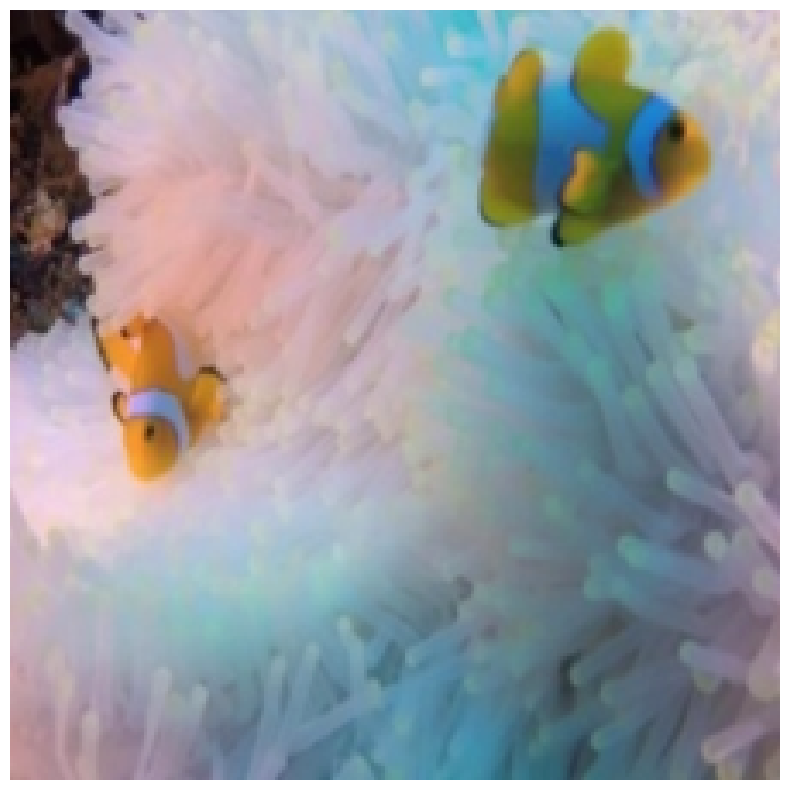

In [ ]:
grid_numpy = original_image.cpu().permute(1, 2, 0).numpy()

# Plot the grid using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(grid_numpy)
plt.axis('off')
plt.show()

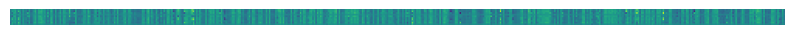

In [ ]:
grid_numpy = encoded.cpu().numpy()

# Plot the grid using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(grid_numpy)
plt.axis('off')
plt.show()

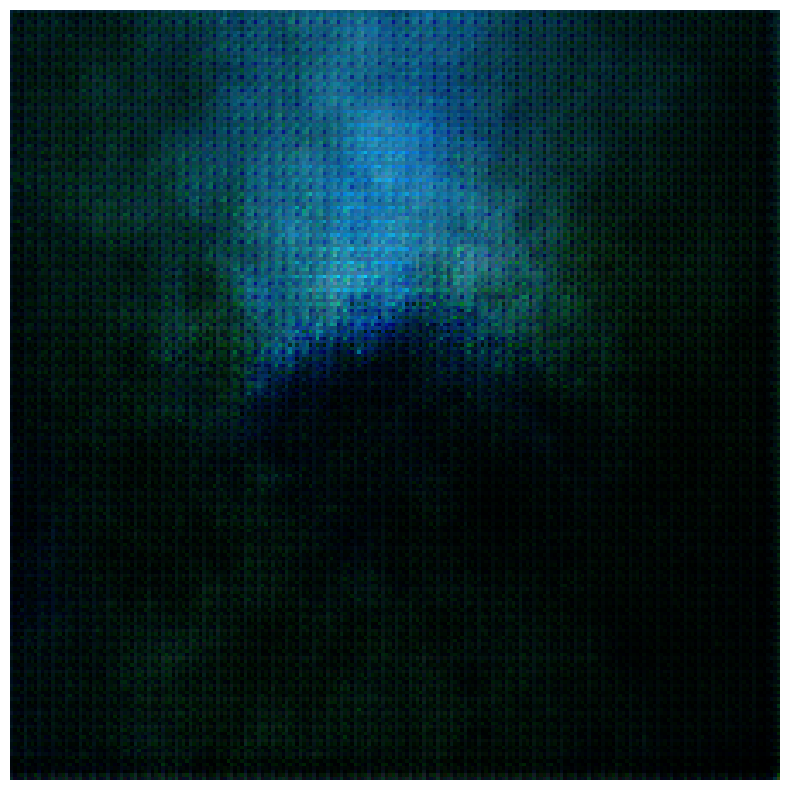

In [ ]:
grid_numpy = decoded_image.cpu().permute(1, 2, 0).numpy()

# Plot the grid using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(grid_numpy)
plt.axis('off')
plt.show()

In [ ]:
images

224

In [ ]:
images = torch.stack(images).to(device)

In [ ]:
images.shape

torch.Size([10, 3, 224, 224])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(64 * (input_shape[1] // 4) * (input_shape[2] // 4), latent_dim)
        self.fc_logvar = nn.Linear(64 * (input_shape[1] // 4) * (input_shape[2] // 4), latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * (input_shape[1] // 4) * (input_shape[2] // 4)),
            nn.Unflatten(1, (64, input_shape[1] // 4, input_shape[2] // 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Training loop
def train_vae(model, train_loader, val_loader, epochs, lr, device):
    model = model.to(device)
    reconstruction_criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss = 0.0
        for data in train_loader:
            inputs = data.to(device)
            optimizer.zero_grad()
            outputs, mu, logvar = model(inputs)
            reconstruction_loss = reconstruction_criterion(outputs, inputs)
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_divergence

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)

        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs = data.to(device)
                outputs, mu, logvar = model(inputs)
                reconstruction_loss = reconstruction_criterion(outputs, inputs)
                kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = reconstruction_loss + kl_divergence
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return model

In [ ]:
model = VAE((3,224,224), 500)
train_vae(model, train_loader, val_loader, 30, 0.005, device)

Epoch: 1, Train Loss: 2591.317444, Val Loss: 1.428901
Epoch: 2, Train Loss: 1.069479, Val Loss: 0.891592
Epoch: 3, Train Loss: 0.824823, Val Loss: 0.739427
Epoch: 4, Train Loss: 0.687515, Val Loss: 0.618100
Epoch: 5, Train Loss: 0.577667, Val Loss: 0.521866
Epoch: 6, Train Loss: 0.491406, Val Loss: 0.447090
Epoch: 7, Train Loss: 0.425175, Val Loss: 0.390490
Epoch: 8, Train Loss: 0.375714, Val Loss: 0.348859
Epoch: 9, Train Loss: 0.339794, Val Loss: 0.319102
Epoch: 10, Train Loss: 0.314459, Val Loss: 0.298427
Epoch: 11, Train Loss: 0.297073, Val Loss: 0.284465
Epoch: 12, Train Loss: 0.285471, Val Loss: 0.275266
Epoch: 13, Train Loss: 0.277949, Val Loss: 0.269401
Epoch: 14, Train Loss: 0.273208, Val Loss: 0.265783
Epoch: 15, Train Loss: 0.270303, Val Loss: 0.263581
Epoch: 16, Train Loss: 0.268582, Val Loss: 0.262318
Epoch: 17, Train Loss: 0.267597, Val Loss: 0.261598
Epoch: 18, Train Loss: 0.267057, Val Loss: 0.261199
Epoch: 19, Train Loss: 0.266786, Val Loss: 0.261023
Epoch: 20, Train L

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=200704, out_features=500, bias=True)
  (fc_logvar): Linear(in_features=200704, out_features=500, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=200704, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 56, 56))
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [ ]:
m